In [1]:
#Set working directory
setwd("~/U_of_H/FALL_2021/Data_ARMS")

#load necessary packages
library("dplyr")
library("ggplot2")
library("data.table")
library ("magrittr")
library("plyr")
library("reshape2")
library("tidyr")
library("RColorBrewer")
library("colorRamps")
library("vegan")
library("indicspecies")
library("stats")

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'data.table' was built under R version 3.6.3"
Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

Warning message:
"package 'magrittr' was built under R version 3.6.3"Warning message:
"package 'plyr' was built under R version 3.6.3"------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: 'plyr'

The following objects are masked from 'package

## upload 3 files:  taxonomy table, ASV table and meta data 

In [11]:

read_3_files <- function (taxonomy_df, Abundance_ASV_df, meta_data_df) { 
    
    taxonomy_DNA <- as.data.frame(fread(taxonomy_df))
    ASV_table_DNA <- as.data.frame(fread (Abundance_ASV_df, header = TRUE))
    metadata_df_DNA <- as.data.frame(fread (meta_data_df))
 
    #set row.names properly for taxonomy and ASV and metadata files
    rownames(ASV_table_DNA) <- ASV_table_DNA$ID_ASV
    rownames(taxonomy_DNA) <- taxonomy_DNA$ID_ASV
    rownames(metadata_df_DNA) <- metadata_df_DNA$Sample  
    
    assign("taxonomy_DNA", taxonomy_DNA, envir = .GlobalEnv)
    assign("ASV_table_DNA", ASV_table_DNA, envir = .GlobalEnv)
    assign("metadata_df_DNA", metadata_df_DNA, envir = .GlobalEnv)
    
}  

read_3_files("Assignation_Taxonomique_MBIO612_ARMS_COI_GM.csv", "ASV_Table_Abondance_nochim_MBIO612_ARMS_GM.csv", "GabyMetaData_ARMS_COI_2021.csv")

## Merge full tables

In [12]:

merge_full_table <- function (taxonomy_DNA, ASV_table_DNA) {
    
    #Merge Taxonomy and ASV tables into a new object
    combined_table <- join(taxonomy_DNA, ASV_table_DNA)
    rownames(combined_table) <- rownames(ASV_table_DNA)


    #delete useless ID_ASV column for taxonxomy and ASV tables
    ASV_table_DNA$ID_ASV <- NULL
    taxonomy_DNA$ID_ASV <- NULL
    combined_table$ID_ASV <- NULL
    
     assign("combined_table", combined_table, envir = .GlobalEnv)
    
    }

merge_full_table(taxonomy_DNA, ASV_table_DNA)

Joining by: ID_ASV


## Tables data wrangling

In [28]:
#Remove the ASVs that haven't been classified up to the desired taxonomic level (ex: exclude ASV that haven't been anotated to the phylum level)

combine_tax_abundance <- function (combined_full_df, taxa_col) {
    
    combined_df_working <- combined_full_df %>%  filter({{taxa_col}} != "")
    
    assign ("combined_df_working", combined_df_working , envir = .GlobalEnv)
    
      }

combine_tax_abundance(combined_table, phylum)

In [32]:
#flip the taxonomic/abundance

flip_df <- function (df) {
    
    flipped_df_working <- data.frame (t(df))
    
     assign ("flipped_df_working", flipped_df_working, envir = .GlobalEnv)
    
     }

flip_df(combined_df_working)

In [36]:
#Merge meta data

merge_df <- function (flipped_df, meta_data,  by_row_col) {
    
    
     combined_full_df <- flip_df(flipped_df)
    
     combined_df_Meta_data <- merge (combined_full_df, meta_data, by= substitute(by_row_col), all.y = T)
    
    assign ("combined_df_Meta_data", combined_df_Meta_data, envir = .GlobalEnv)
    
     }

merge_df(combined_df_working, metadata_df_DNA, "row.names")

In [47]:
#Subset Meta data from working df

subset_df_nested <- function (full_df, subset_df) {
    
    Meta_data_working_df <- full_df [,full_df %in% subset_df]
    Meta_data_working_df$Row.names <- row.names(subset_df)
    
    assign("Meta_data_working_df", Meta_data_working_df, envir = .GlobalEnv)
    
     }

subset_df_nested (combined_df_Meta_data, metadata_df_DNA)

In [50]:
#Subset ASV abundance from working df

subset_numeric_df <- function (full_df) {
    
    ASV_DNA_working_df <- full_df [sapply(full_df, is.numeric)]
    assign("ASV_DNA_working_df", ASV_DNA_working_df, envir = .GlobalEnv)
    
    
     }

subset_numeric_df (combined_df_working)

In [53]:
#Subset taxonomy from working df

subset_join <- function (full_df, subset_df) {
    
    taxonomy_DNA_working_df <- semi_join(subset_df, full_df)
    assign("taxonomy_DNA_working_df", taxonomy_DNA_working_df, envir = .GlobalEnv)
    
     }

subset_join (combined_df_working, taxonomy_DNA)

Joining, by = c("kingdom", "phylum", "class", "order", "family", "genus", "species")


In [55]:
#long version of the table

elongate_df <- function (full_df, names_df) {
    
    long_combined_ASV_Meta_data_df <- melt(full_df, id= names (names_df))

    assign("long_combined_ASV_Meta_data_df", long_combined_ASV_Meta_data_df, envir = .GlobalEnv)
    
     }

elongate_df(combined_df_Meta_data, Meta_data_working_df)

Warning message:
"attributes are not identical across measure variables; they will be dropped"

In [125]:
 #merge flipped ASV_table working with meta data: no taxonomy

flipped_df_subset <- function (full_df, meta_data_df) {
    
    t_ASV_table_DNA_working <- flip_df (full_df)
    
    metadata_df <- meta_data_df %>%
    mutate_all(as.character)
    
    row.names(metadata_df)<- metadata_df$Sample

    flipped_ASV_Meta_data_working <- na.omit(merge(t_ASV_table_DNA_working, metadata_df, by="row.names",all.y=T))

    rownames(flipped_ASV_Meta_data_working) <- flipped_ASV_Meta_data_working[,1]

    flipped_ASV_Meta_data_working$Row.names <- NULL
    
    assign("flipped_ASV_Meta_data_working_df", flipped_ASV_Meta_data_working, envir = .GlobalEnv)
    assign("t_ASV_table_DNA_working",  t_ASV_table_DNA_working,  envir = .GlobalEnv)


     }

flipped_df_subset(ASV_DNA_working_df, metadata_df_DNA)

In [66]:
#Subset so no more meta data: flipped ASV table

subset_no_character_df <- function (full_df) {
    
    flipped_ASV_DNA_working_df <- full_df [!(sapply(full_df, is.character))]
    
    assign("flipped_ASV_DNA_working_df",  flipped_ASV_DNA_working_df, envir = .GlobalEnv)
    
    
     }

subset_no_character_df(flipped_ASV_Meta_data_working_df)

In [69]:
#flipped meta data
   
subset_character_df <- function (full_df) {
    
    flipped_Meta_data_working_df <- full_df [(sapply(full_df, is.character))]
    
    assign("flipped_Meta_data_working_df", flipped_Meta_data_working_df, envir = .GlobalEnv)
    
     }

subset_character_df(flipped_ASV_Meta_data_working_df)


## Barplot for taxonomic diversity

In [73]:
#Function : select the 20 most abundant taxa (ex:families) and combute the abundance of ASV for each of them

#select the taxa column
 extract_taxa_col <- function (working_taxonomy_table, taxa_col) {
    
   taxonomy_taxa <- working_taxonomy_table %>% 
    select ((.data[[taxa_col]]))
    
    taxonomy_taxa["variable"] <- row.names(taxonomy_taxa)
     
    assign("taxonomy_taxa", taxonomy_taxa, envir = .GlobalEnv)
     
      }

extract_taxa_col(taxonomy_DNA_working_df, "family")


In [75]:
#Add the taxa col to the elongated table

add_extracted_taxa_long_df <- function (long_df, working_taxonomy_table, taxa, by_variable) {
    
    taxa_col <- extract_taxa_col(working_taxonomy_table, taxa)
    
  
    Extracted_taxa_long_df <- merge (long_df, taxa_col, by= substitute(by_variable))
    
    
    Extracted_taxa_long_df <- data.frame (Extracted_taxa_long_df, stringsAsFactors = TRUE)

   
    Extracted_taxa_long_df [,by_variable] <- factor(Extracted_taxa_long_df[,by_variable])

   
    assign("Extracted_taxa_long_df", Extracted_taxa_long_df, envir = .GlobalEnv)
    
     }

add_extracted_taxa_long_df (long_combined_ASV_Meta_data_df, taxonomy_DNA_working_df, "family", "variable")

In [82]:
#Select only the data that is anotated to the given taxa level

    select_taxa_only <- function (combined_full_df, taxa) {
    
    long_taxa_ASV_df <- combine_tax_abundance (combined_full_df, {{taxa}})
    
    #Make the value column numeric
    
    long_taxa_ASV_df[,"value"] <- as.integer(long_taxa_ASV_df[,"value"])

    assign("long_taxa_ASV_df",  long_taxa_ASV_df, envir = .GlobalEnv)
    
      }

select_taxa_only(Extracted_taxa_long_df, family)

In [88]:
##Select the 20 most abundant families/phylum (taxa) and label and combine the other ones as other labelled the "others" together

subset_20_most_abundant_and_others <- function (Taxa_only_df, taxa_name) {

Taxa_ASV_abundant <- Taxa_only_df %>%
  group_by({{taxa_name}}) %>%
  drop_na() %>%
  dplyr::summarize (sum_asv= sum(value)) %>%
  arrange(desc(sum_asv)) %>%
  mutate (sum_asv_cumul =  if_else (row_number (sum_asv)< (length(sum_asv)-19), "Other", as.character(sum_asv))) %>%
  mutate(sum_asv = replace(sum_asv, sum_asv_cumul == "Other", sum(sum_asv[sum_asv_cumul == "Other"]))) 

    assign("Taxa_ASV_abundant",  Taxa_ASV_abundant, envir = .GlobalEnv)
}

subset_20_most_abundant_and_others(long_taxa_ASV_df, family)

In [97]:
#Replace the last 20 families by others

Group_others <- function (Taxa_only_df, taxa_name) {
    
    length_df <- nrow (Taxa_only_df)
    
    Taxa_only_df[21:length_df, taxa_name] <- "Other"
    
    Taxa_ASV_abundant_other <- Taxa_only_df
    
    assign("Taxa_ASV_abundant_other",  Taxa_ASV_abundant_other, envir = .GlobalEnv)
}

Group_others(Taxa_ASV_abundant, "family")

In [101]:
#Add meta data to families

add_meta_data <- function (Taxa_df, meta_data, taxa_name) {
    
    Taxa_df_Meta_data <- merge(Taxa_df, meta_data, by= substitute(taxa_name))
    
    Taxa_df_Meta_data [,"sum_asv_cumul"] <- NULL
    
    assign("Taxa_df_Meta_data",  Taxa_df_Meta_data, envir = .GlobalEnv)
  
}

add_meta_data(long_taxa_ASV_df, Taxa_ASV_abundant_other, "family")

In [104]:
#Find the mean number of ASV per taxa per factor 

calculate_mean_ASV_factor <- function (meta_data_ASV_df, taxa_name, factor_col) {
    
 meta_data_ASV_df[,"value"] <- as.numeric(meta_data_ASV_df[,"value"])
    
    
    ASV_per_group_per_taxa <- meta_data_ASV_df %>%
       dplyr::group_by(.data[[factor_col]], .data[[taxa_name]]) %>%
       dplyr::summarize(mean_abundance_ASV_group =  mean(value,na.rm=T))
    
    assign("ASV_per_group_per_taxa",  ASV_per_group_per_taxa, envir = .GlobalEnv)
}
 
calculate_mean_ASV_factor (Taxa_df_Meta_data, "family", "Island")

`summarise()` has grouped output by 'Island'. You can override using the `.groups` argument.


In [109]:
#calculate mean number of ASV per sample per factor

calculate_mean_ASV_factor <- function (meta_data_ASV_df, ASV_col, factor_col) {
    
    ASV_per_group <- meta_data_ASV_df %>%
       dplyr::group_by(.data[[ASV_col]], .data[[factor_col]]) %>%
        dplyr::summarize(sum_abundance_ASV_factor = sum(value, na.rm = T))
    
    
    
    Mean_ASV_per_sample_for_ea_factor <- ASV_per_group %>%
    dplyr::group_by(.data[[factor_col]]) %>%
    dplyr::summarize (mean_abundance_ASV_factor = mean(sum_abundance_ASV_factor, na.rm= TRUE))
    
    assign("ASV_per_group",  ASV_per_group, envir = .GlobalEnv)
    assign("Mean_ASV_per_sample_for_ea_factor", Mean_ASV_per_sample_for_ea_factor, envir = .GlobalEnv)

}

calculate_mean_ASV_factor(Taxa_df_Meta_data, "variable", "Island")

`summarise()` has grouped output by 'variable'. You can override using the `.groups` argument.


In [114]:
#merge the two data frames

merge_factor_barplot <- function (mean_ASV_factor_df, factor_taxa_df, factor_name) {
    
    factor_barplot_df <- merge (mean_ASV_factor_df, factor_taxa_df, by= substitute(factor_name))
    
    assign("factor_barplot_df", factor_barplot_df, envir = .GlobalEnv)

    
}

merge_factor_barplot(Mean_ASV_per_sample_for_ea_factor, ASV_per_group_per_taxa, "Island")

In [118]:
#Make and extend color palette for graph

make_color_palette <- function (number_palette, number_taxa) {
    
    color_barplot <- brewer.pal(number_palette, "Paired") 
    
    color_barplot <-  colorRampPalette(color_barplot)(number_taxa)
    
    assign("color_barplot", color_barplot, envir = .GlobalEnv)
    
}

make_color_palette(12,21)

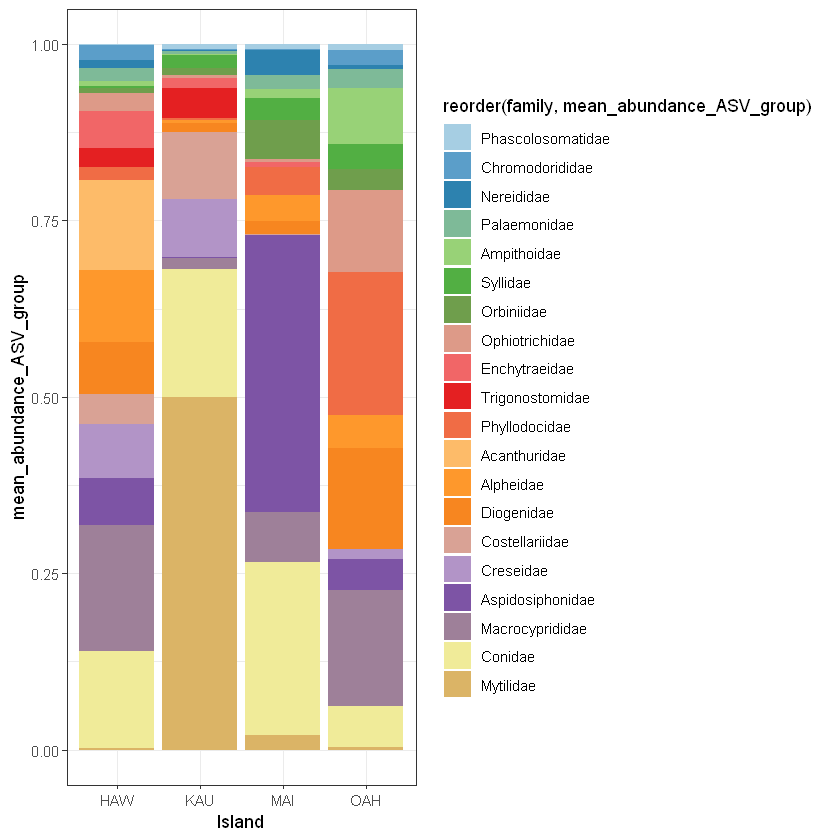

In [122]:
#plot

plot_taxonomic_barplot <- function (barplot_data_df, color_palette, taxa_name, factor) {
    
taxonomic_barplot <-ggplot(barplot_data_df, aes (fill = reorder(.data[[taxa_name]], mean_abundance_ASV_group), y= mean_abundance_ASV_group, x= .data[[factor]]))+
    
    geom_bar (position="fill",  stat= "identity") + theme_bw() +
    
    scale_fill_manual(values=color_palette)
    
    taxonomic_barplot
    
}

plot_taxonomic_barplot(factor_barplot_df, color_barplot, "family", "Island")

## Beta diversity analysis (PERMANVOA + NMDS)

In [128]:
#compute PERMANVOA function

compute_PERMANOVA <- function (ASV_df, grouping_factor, data_df, method_distance) {
    
    factor = data_df[,grouping_factor]
  
    PERMANOVA <- adonis (ASV_df ~ factor, data= data_df, permutations = 9999, method = {{method_distance}}, na.rm=T)
    
    return (PERMANOVA)
}

compute_PERMANOVA (flipped_ASV_DNA_working_df, "Island", flipped_ASV_Meta_data_working_df, "bray")


Call:
adonis(formula = ASV_df ~ factor, data = data_df, permutations = 9999,      method = {         {             method_distance         }     }, na.rm = T) 

Permutation: free
Number of permutations: 9999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
factor      3     6.196 2.06548  5.1845 0.11559  1e-04 ***
Residuals 119    47.408 0.39839         0.88441           
Total     122    53.605                 1.00000           
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [130]:
#obtain distance matice for NMDS 1 and 2

compute_distance_dissimilarity_matrice <- function (ASV_df, method_distance, Meta_data) {
    
    distances <- vegdist(ASV_df, method= {{method_distance}}, na.rm=T)
    
    coordinates <- metaMDS(distances)

    scores_table <- as.data.frame(scores(coordinates))
    
    scores_table_NMDS <- merge(scores_table, Meta_data, by="row.names", all.x=T)
    
    assign("scores_table_NMDS", scores_table_NMDS, envir = .GlobalEnv)
    
  
    
}

compute_distance_dissimilarity_matrice(flipped_ASV_DNA_working_df, "bray", flipped_Meta_data_working_df)

Run 0 stress 0.2569125 
Run 1 stress 0.2691009 
Run 2 stress 0.2813503 
Run 3 stress 0.2723206 
Run 4 stress 0.2819707 
Run 5 stress 0.2605186 
Run 6 stress 0.2595464 
Run 7 stress 0.2606033 
Run 8 stress 0.279841 
Run 9 stress 0.2816009 
Run 10 stress 0.2733507 
Run 11 stress 0.2771447 
Run 12 stress 0.2658481 
Run 13 stress 0.2641323 
Run 14 stress 0.2804458 
Run 15 stress 0.2937344 
Run 16 stress 0.2817371 
Run 17 stress 0.262934 
Run 18 stress 0.280191 
Run 19 stress 0.2739875 
Run 20 stress 0.2646753 
*** No convergence -- monoMDS stopping criteria:
    19: stress ratio > sratmax
     1: scale factor of the gradient < sfgrmin


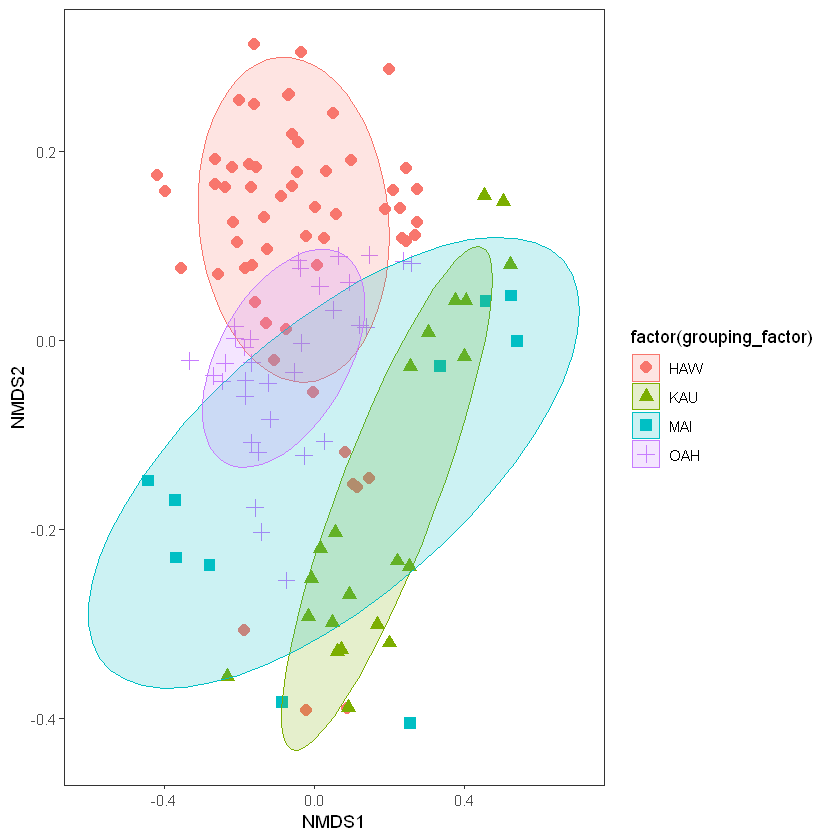

In [131]:
#Plot NMDS

plot_NMDS <- function (scores_table_meta_data_df, factor) {
    
    grouping_factor = scores_table_meta_data_df[,factor]
    
   NMDS <- ggplot(scores_table_meta_data_df)+
    geom_point(data =scores_table_meta_data_df, aes(x=NMDS1, y= NMDS2, shape=factor(grouping_factor), colour=factor(grouping_factor),fill=factor(grouping_factor)),size=3)+
   stat_ellipse(geom = "polygon",aes(x=NMDS1, y=NMDS2, color= factor(grouping_factor), fill =factor(grouping_factor)), alpha=0.2, level=0.7)+
   theme_bw()+ 
    theme(panel.grid.major=element_line(colour="white"), panel.grid.minor=element_line(colour="white"), strip.background = element_rect(fill="white"))

NMDS
    
}

plot_NMDS(scores_table_NMDS, "Island")